# Modelling and Evaluation Notebook

## Objectives

*   Answer business requirement 2: 
    * The client is interested in predicting if a cherry tree is healthy or contains powdery mildew.


## Inputs

* inputs/cherry-leaves/cherry-leaves/train
* inputs/cherry-leaves/cherry-leaves/test
* inputs/cherry-leaves/cherry-leaves/validation
* image shape embeddings.

## Outputs
* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.




## Additional Comments | Insights | Conclusions




---

---

# Import regular packages

In [51]:
%pip install -r /workspace/powdery_mildew_detector/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [52]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set Working Directory

In [53]:
cwd= os.getcwd()

In [54]:
os.chdir('/workspace/powdery_mildew_detector')
print("You set a new current directory")

You set a new current directory


In [55]:

work_dir = os.getcwd()
work_dir

'/workspace/powdery_mildew_detector'

---

## Set input directories

Set train, validation and test paths

In [56]:
my_data_dir = 'inputs/cherry-leaves/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [57]:
version = 'v7'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)


Old version is already available create a new version.


## Set labels

In [58]:

labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)


Project Labels: ['healthy', 'powdery_mildew']


## Set image shape

In [59]:
## Import saved image shape embedding
import joblib
version = 'v7'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Number of images in train, test and validation data

          Set           Label  Frequency
0       train         healthy       1472
1       train  powdery_mildew       1472
2  validation         healthy        210
3  validation  powdery_mildew        210
4        test         healthy        422
5        test  powdery_mildew        422


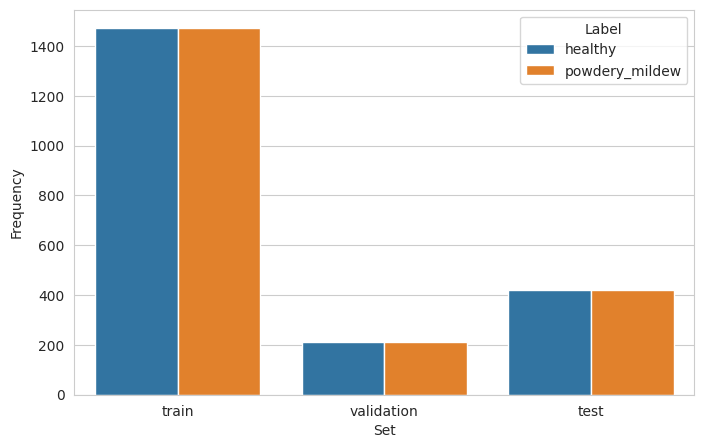

In [60]:
all_data = []

for folder in ['train', 'validation', 'test']:
    for label in labels:
        folder_path = os.path.join(my_data_dir, folder, label)
        num_images = len(os.listdir(folder_path))
        
        all_data.append({
            'Set': folder,
            'Label': label,
            'Frequency': num_images
        })

# Create the DataFrame in one go
df_freq = pd.DataFrame(all_data)

print(df_freq)

sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show() 

---

# Image data augmentation

---

### ImageDataGenerator

In [61]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* ### Initialize ImageDataGenerator

In [62]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )


* ### Augment training image dataset

In [63]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices


Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment validation image dataset

In [64]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices


Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment test image dataset

In [65]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices


Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image

In [66]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


(20, 256, 256, 3)


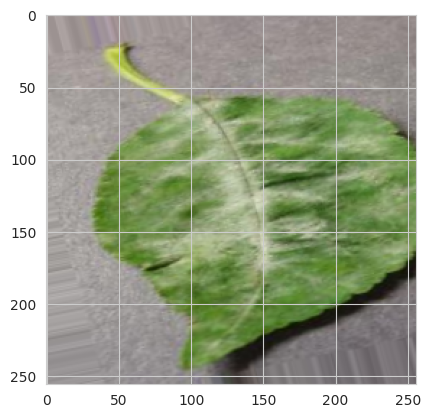

(20, 256, 256, 3)


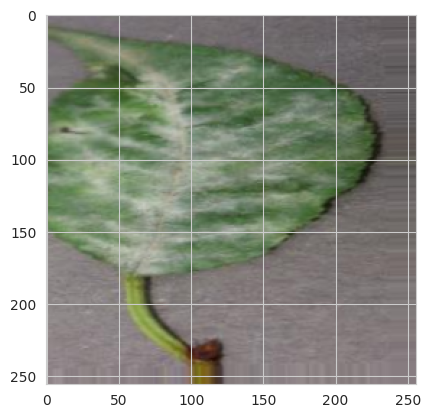

(20, 256, 256, 3)


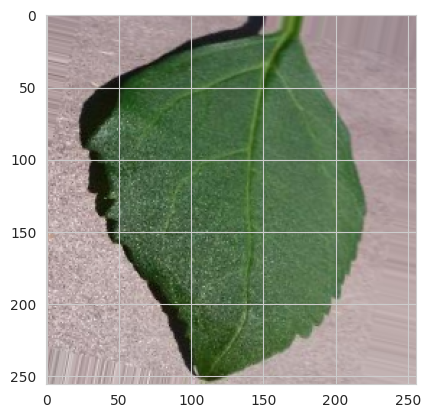

In [67]:
for _ in range(3):
    # img, label = train_set.next()
    img, label = next(iter(train_set))
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()
 


## Plot augmented validation and test images

(20, 256, 256, 3)


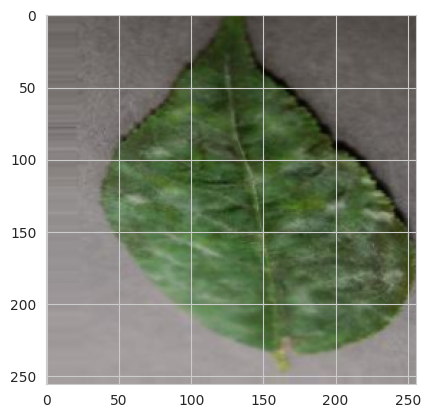

(20, 256, 256, 3)


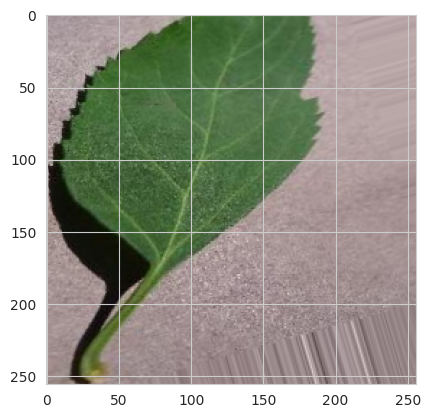

(20, 256, 256, 3)


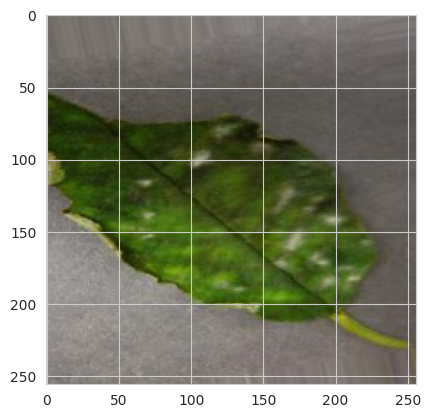

In [68]:
for _ in range(3):
    # img, label = validation_set.next()
    img, label = next(iter(train_set))
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


(20, 256, 256, 3)


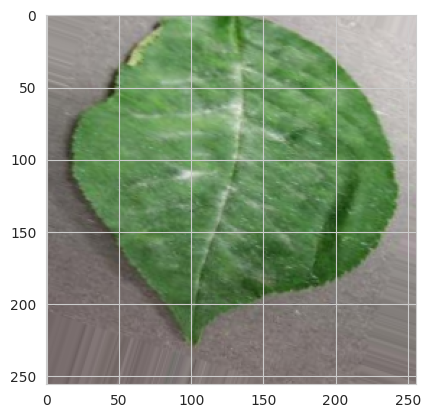

(20, 256, 256, 3)


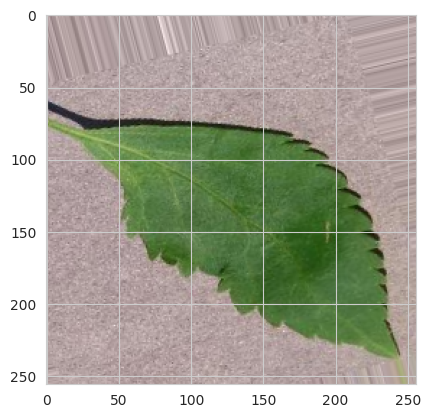

(20, 256, 256, 3)


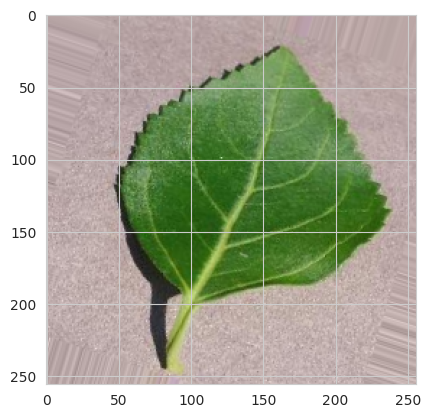

In [69]:
for _ in range(3):
    # img, label = test_set.next()
    img, label = next(iter(train_set))
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


## Save class_indices

In [70]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")


['outputs/v7/class_indices.pkl']

---

# Model creation

---

## ML model

* ### Import model packages

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model 

In [72]:
def create_tf_model():
    
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))

    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='binary_crossentropy',
    # model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    return model


* ### Model Summary 

In [73]:
create_tf_model().summary()

/home/gitpod/.pyenv/versions/3.12.6/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,742,914 (14.28 MB)

 Trainable params: 3,742,914 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

* ### Early Stopping 

In [74]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)


## Fit model for model training

In [75]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )


Epoch 1/25


/home/gitpod/.pyenv/versions/3.12.6/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


147/147 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.6834 - loss: 0.5642 - val_accuracy: 0.9905 - val_loss: 0.0497
Epoch 2/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 3:37 1s/step - accuracy: 1.0000 - loss: 0.0873

2024-09-28 10:42:24.560222: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/gitpod/.pyenv/versions/3.12.6/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 1.0000 - loss: 0.0873 - val_accuracy: 0.9548 - val_loss: 0.1079
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.9708 - loss: 0.1110 - val_accuracy: 0.9929 - val_loss: 0.0474
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 1.0000 - loss: 0.0546 - val_accuracy: 0.9929 - val_loss: 0.0508
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.9849 - loss: 0.0820 - val_accuracy: 0.9952 - val_loss: 0.0156
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9500 - loss: 0.1075 - val_accuracy: 0.9905 - val_loss: 0.0352
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.9881 - loss: 0.0703 - val_accuracy: 0.9976 - val_loss: 0.0110
Epoch 8/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 1.0000 - loss: 0.0366 - val_accuracy: 0.9976 - val_loss: 0.0107
Epoch 9/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.9905 - loss: 0.0717 - val_accuracy: 0.

## Save model

In [76]:
# model.save('outputs/v1/cherry_leaves_model.h5')
model.save('outputs/v7/cherry_leaves_model.keras')


---

# Model Performace

---

## Model learning curve

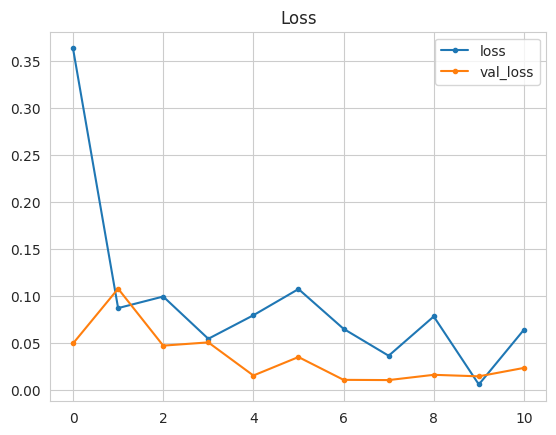

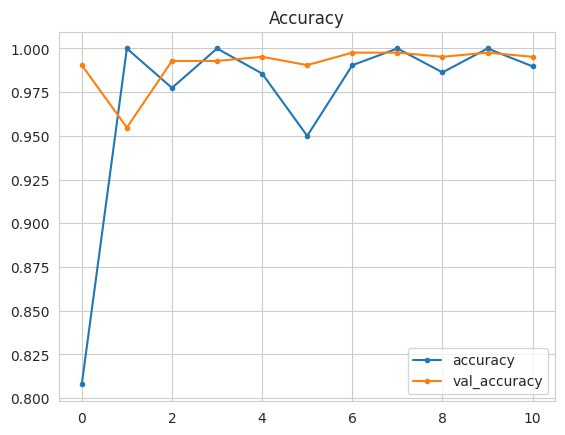

In [77]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()


## Model Evaluation

Load saved model

In [78]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [79]:
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from keras.models import load_model
# model = load_model('outputs/v1/cherry_leaves_model.h5')
model = load_model('outputs/v7/cherry_leaves_model.keras')

Evaluate model on test set

In [80]:
evaluation = model.evaluate(test_set)


/home/gitpod/.pyenv/versions/3.12.6/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 391ms/step - accuracy: 0.9985 - loss: 0.0098


# Create a confusion Matrix

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 391ms/step


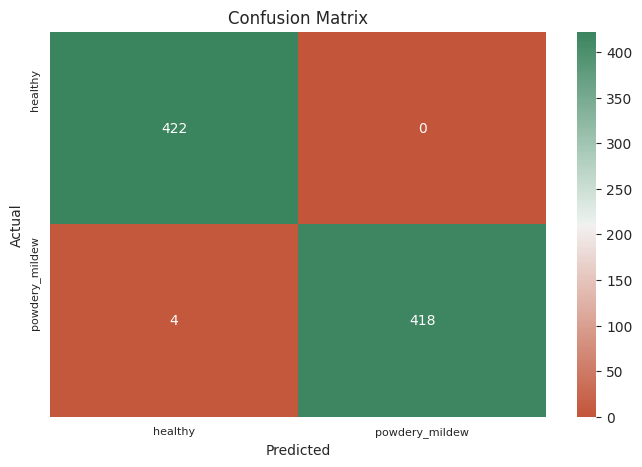

In [81]:


validation_set.reset()


x_true, y_true = next(test_set)
preds = np.argmax(model.predict(test_set), axis=1)
y_pred = np.rint(preds)
y_true = test_set.labels


cm = confusion_matrix(y_true,y_pred)
sns_colours = sns.diverging_palette(20, 145, as_cmap=True)


classes=list(test_set.class_indices.keys())
length = len(classes)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap=sns_colours)       
plt.xticks(np.arange(length) + .5, classes, rotation=0, fontsize=8)
plt.yticks(np.arange(length) + .3, classes, rotation=90, fontsize=8)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f'{file_path}/confusion_matrix.png',
            bbox_inches='tight', dpi=150)
plt.show()



### Save evaluation pickle

In [82]:
joblib.dump(value=evaluation,
            filename=f"outputs/v7/evaluation.pkl")


['outputs/v7/evaluation.pkl']

## Predict on new data

Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


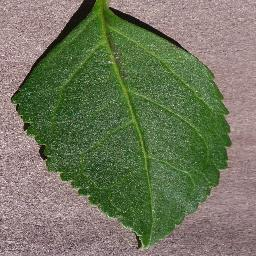

In [83]:
from tensorflow.keras.preprocessing import image

pointer = 99
label = labels[0]  # select healthy (0) or powdery mildew (1)  

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image


Convert image to array and prepare for prediction

In [84]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [94]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba < 0.5]

if pred_class == target_map[1]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

    


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1.0
healthy


---

# Push files to Repo

## Push generated/new files from this Session to your GitHub repo

* .gitignore

In [86]:
!cat .gitignore

kaggle.json
__pycache__/
outputs/v1
outputs/v6
inputs/cherry-leaves/cherry-leaves/test
inputs/cherry-leaves/cherry-leaves/train

* Git status

In [87]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   .gitignore
	modified:   .slugignore
	deleted:    inputs/cherry-leaves/cherry-leaves/validation/healthy/01958ee7-f585-4956-90aa-a40dc79102d4___JR_HL 9836.JPG
	deleted:    inputs/cherry-leaves/cherry-leaves/validation/healthy/02818f40-58e6-4c7d-bfbc-372d89b2045b___JR_HL 4259.JPG
	deleted:    inputs/cherry-leaves/cherry-leaves/validation/healthy/036b575a-cbe7-45a4-8b97-15b7ecdf3dee___JR_HL 9600.JPG
	deleted:    inputs/cherry-leaves/cherry-leaves/validation/healthy/0a68b3a9-e38f-45b5-8664-9c60e557a41d___JR_HL 9511.JPG
	deleted:    inputs/cherry-leaves/cherry-leaves/validation/healthy/0b2ed0b4-a6e1-4fb3-82dc-47f903f3d0a9___JR_HL 9603.JPG
	deleted:    inputs/cherry-leaves/cherry-leaves/validation/healthy/1075f5f1-8cfe-420a-a65d-7c3399b63f39___JR_HL 9827.

* Git add

In [88]:
!git add .

* Git commit

In [89]:
!git commit -am "Working model changed inverted result"

[main f6b70b0] Working model fixed typo in app_pages
 777 files changed, 222 insertions(+), 553 deletions(-)
 create mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/0008f3d3-2f85-4973-be9a-1b520b8b59fc___JR_HL 4092.JPG
 create mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/002efba9-09b3-43de-93b7-5c2460185cde___JR_HL 9655.JPG
 delete mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/01958ee7-f585-4956-90aa-a40dc79102d4___JR_HL 9836.JPG
 delete mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/02818f40-58e6-4c7d-bfbc-372d89b2045b___JR_HL 4259.JPG
 delete mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/036b575a-cbe7-45a4-8b97-15b7ecdf3dee___JR_HL 9600.JPG
 create mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/036b575a-cbe7-45a4-8b97-15b7ecdf3dee___JR_HL 9600_180deg.JPG
 create mode 100644 inputs/cherry-leaves/cherry-leaves/validation/healthy/0438b691-45f8-4251-83bd-8344656716a1___JR_

* Git Push

In [90]:
!git push

Enumerating objects: 426, done.
Counting objects: 100% (426/426), done.
Delta compression using up to 32 threads
Compressing objects: 100% (404/404), done.
Writing objects: 100% (410/410), 45.89 MiB | 13.47 MiB/s, done.
Total 410 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
remote: Resolving deltas: 100% (6/6), completed with 6 local objects.
To https://github.com/nianswe/powdery_mildew_detector.git
   fc64298..f6b70b0  main -> main


---